In [3]:
using CSV, DataFrames, Dates, Statistics, JuMP, Ipopt, PyPlot, LinearAlgebra
# --- Data Preparation ---

# Define the directory containing the stock CSV files
directory_path = "data_files/"

# Initialize an empty DataFrame to hold daily returns
returns_df = DataFrame(Date = Date[])

# Read each stock CSV file and compute daily returns
for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)

        # Ensure the Date column is of Date type
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)

        stock_name = splitext(basename(file))[1]

        # Calculate daily logarithmic returns
        stock_df[!, :DailyReturn] = [missing; diff(log.(stock_df.Close))]

        # Create a DataFrame with Date and DailyReturn
        stock_returns = stock_df[:, [:Date, :DailyReturn]]
        rename!(stock_returns, :DailyReturn => stock_name)

        # Merge with the returns_df
        if nrow(returns_df) == 0
            returns_df = stock_returns
        else
            returns_df = outerjoin(returns_df, stock_returns, on = :Date)
        end
    end
end

# Remove rows with missing values
complete_cases = dropmissing(returns_df, disallowmissing=true)


In [4]:
# --- Extract Asset Names and Prepare Data ---

# Extract asset names excluding the Date column
# Check the type of column names
col_names = names(complete_cases)
println("Column names:", col_names)
println("Type of column names:", typeof.(col_names))

# Adjust based on the type
if eltype(col_names) == String
    asset_names = setdiff(col_names, ["Date"])
elseif eltype(col_names) == Symbol
    asset_names = setdiff(col_names, [:Date])
else
    error("Unexpected column name types.")
end

# Convert asset_names to strings if necessary
asset_names = string.(asset_names)

# Verify lengths
println("Number of asset names:", length(asset_names))

# Extract the matrix of returns (excluding the Date column)
returns_matrix = Matrix(complete_cases[:, asset_names])

In [3]:
# --- Compute Expected Returns and Covariance Matrix ---

trading_days_per_year = 252  # Number of trading days in a year

# Compute expected daily returns
μ_daily = mean(returns_matrix, dims=1)
μ_daily = vec(μ_daily)  # Convert to a vector

# Annualize expected returns (using compounding)
μ = (1 .+ μ_daily) .^ trading_days_per_year .- 1

# Verify length of μ
println("Length of μ:", length(μ))

# Compute daily covariance matrix
Σ_daily = cov(returns_matrix, dims=1)

# Annualize covariance matrix
Σ = Σ_daily * trading_days_per_year

# Verify size of Σ
println("Size of Σ:", size(Σ))

# Number of assets
n_assets = length(μ)
println("Number of assets (n_assets):", n_assets)


In [1]:
# --- Portfolio Optimization ---

R_min = 0 
λ = 0     # Risk aversion parameter
γ = 1000        # Diversification parameter

# Create optimization model
m = Model(Ipopt.Optimizer)

@variable(m, x[1:n_assets] >= 0)
@constraint(m, sum(x) == 1)
@constraint(m, μ' * x >= R_min)
#@constraint(m, [i in 1:n_assets], x[i] <= 0.15)

@objective(m, Min, -μ' * x + λ * (x' * Σ * x) + γ * sum(x[i]^2 for i in 1:n_assets))

# Solve the model
optimize!(m)

# Check solution status
status = termination_status(m)
display(status)

if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
    println("The model is feasible.")

    # Extract optimal portfolio weights
    portfolio_weights = value.(x)

    # Compute portfolio return and risk
    portfolio_return = μ' * portfolio_weights  # Annual expected return
    portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation

    # --- Plotting ---
    figure(figsize=(12, 6))
    bar(1:n_assets, portfolio_weights, color="blue", alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("Optimal Portfolio Weights for R_min = $R_min")
    grid(true)
    tight_layout()
    show()

    # --- Display Portfolio Metrics ---
    println("Portfolio Expected Annual Return: $portfolio_return")
    println("Portfolio Risk (Annual Standard Deviation): $portfolio_risk")
else
    println("The model is not feasible. Status: $status")
end

# Portfolio Optimization Project

### CS/ECE/ISyE 524 — Introduction to Optimization — Fall 2024

### Project Members: Pawin Linmaneechote, Vincent Philavong, Jiajie Yao

## Table of Contents
1. Introduction
2. Mathematical Model
3. Solution
4. Results and Discussion
5. Conclusion
6. Appendix


# 1. Introduction  

Personal finances are confusing. It is almost as if it is its own language with specific jargons and concepts that aren't necessarily intuitive. Among the multitude of strategies for growing wealth, investing in the stock market stands out as a powerful tool to achieve long-term financial goals. 

However, deciding what to invest in is rarely straightforward. There are many factors to consider when choosing what to invest in, but one of the most important questions is, how much potential does this asset have to grow my wealth in the long-term? Understanding these dynamics in investing requires a thoughtful approach, wieghing risk, potential returns, and how this investment fits in with your personal finance goals.



# 2. Mathematical Model

In [4]:
# --- Extract Asset Names and Prepare Data ---

# Extract asset names excluding the Date column
# Check the type of column names
col_names = names(complete_cases)
println("Column names:", col_names)
println("Type of column names:", typeof.(col_names))

# Adjust based on the type
if eltype(col_names) == String
    asset_names = setdiff(col_names, ["Date"])
elseif eltype(col_names) == Symbol
    asset_names = setdiff(col_names, [:Date])
else
    error("Unexpected column name types.")
end

# Convert asset_names to strings if necessary
asset_names = string.(asset_names)

# Verify lengths
println("Number of asset names:", length(asset_names))

# Extract the matrix of returns (excluding the Date column)
returns_matrix = Matrix(complete_cases[:, asset_names])

Column names:["Date", "AAPL", "ABBV", "AMD", "AXP", "BA", "CAT", "DFS", "DIS", "ETN", "GOOG", "GS", "JNJ", "JPM", "META", "MRK", "MSFT", "NFLX", "NVDA", "PFE", "RTX", "SYF", "TMUS", "UBER", "UNH", "UNP"]
Type of column names:DataType[String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String]
Number of asset names:25


1257×25 Matrix{Float64}:
  0.00847742   -0.00085319   0.009694     …   0.0234339    0.00379227
  0.00273312    0.0382776    0.000275651      0.00198668  -0.00515415
  0.00788761    0.00526723   0.000550964     -0.0112708    0.00396712
 -0.000915827   0.00906454   0.010956         0.00455494  -0.00755107
  0.00953603    0.00254191   0.021825        -0.00660351   0.000398803
 -0.00694349    0.0111309    0.0218804    …   0.00887322  -0.00439605
  0.0118093     0.011347     0.00546102       0.0516841    0.00854609
  0.00502947    0.00112772   0.0336595        0.0130181   -0.000113491
 -0.00303718    0.00326295   0.0347454        0.00475188   0.00520627
 -0.0117098    -0.0206567   -0.00753622       0.00483817  -0.0175373
 -0.00449352   -0.00782873  -0.0362773    …   0.00358621   0.000459438
 -0.000878245  -0.00544701  -0.0094064        0.00104811   0.0101112
  0.0173818     0.0196773    0.0162152        0.0208405    0.0222581
  ⋮                                       ⋱               
  0.00

In [1]:
# --- Portfolio Optimization ---

R_min = 0 
λ = 0     # Risk aversion parameter
γ = 1000        # Diversification parameter

# Create optimization model
m = Model(Ipopt.Optimizer)

@variable(m, x[1:n_assets] >= 0)
@constraint(m, sum(x) == 1)
@constraint(m, μ' * x >= R_min)
#@constraint(m, [i in 1:n_assets], x[i] <= 0.15)

@objective(m, Min, -μ' * x + λ * (x' * Σ * x) + γ * sum(x[i]^2 for i in 1:n_assets))

# Solve the model
optimize!(m)

# Check solution status
status = termination_status(m)
display(status)

if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
    println("The model is feasible.")

    # Extract optimal portfolio weights
    portfolio_weights = value.(x)

    # Compute portfolio return and risk
    portfolio_return = μ' * portfolio_weights  # Annual expected return
    portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation

    # --- Plotting ---
    figure(figsize=(12, 6))
    bar(1:n_assets, portfolio_weights, color="blue", alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("Optimal Portfolio Weights for R_min = $R_min")
    grid(true)
    tight_layout()
    show()

    # --- Display Portfolio Metrics ---
    println("Portfolio Expected Annual Return: $portfolio_return")
    println("Portfolio Risk (Annual Standard Deviation): $portfolio_risk")
else
    println("The model is not feasible. Status: $status")
end

LoadError: UndefVarError: `Model` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

running
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:       51
Number of nonzeros in Lagrangian Hessian.............:      352

Total number of variables............................:       26
                     variables with only lower bounds:       26
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9999800e-05 7.50e-01 9.80e-01  -1.0 0.00e+00    -  0.00e+00 0

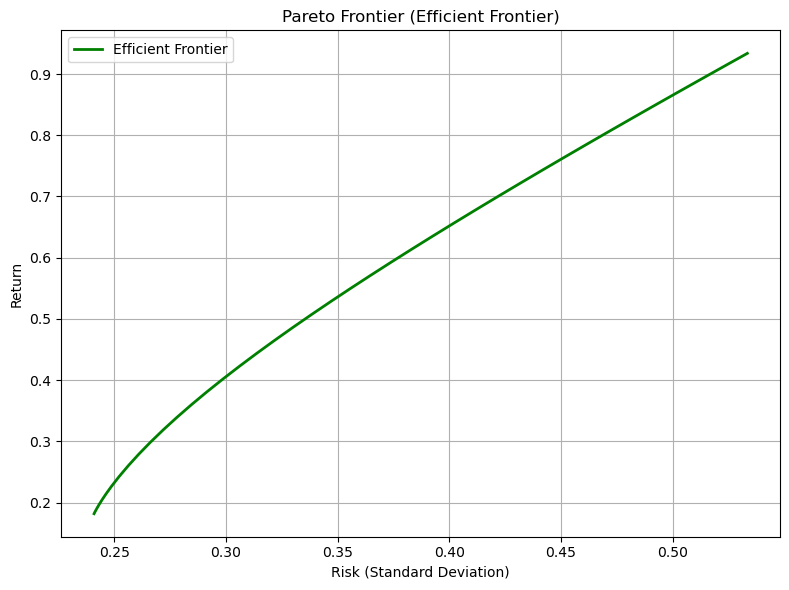

In [9]:
using JuMP
using Ipopt
using LinearAlgebra
using PyPlot

# --- Parameters ---
n_assets = length(μ)  # Number of assets
r_min_values = range(minimum(μ), maximum(μ), length=50)  # Target returns
optimal_risks = []
optimal_returns = []

# Optimization model for each R_min
for r_min in r_min_values
    println("running")
    model = Model(Ipopt.Optimizer)
    
    # Variables
    @variable(model, w[1:n_assets] >= 0)  # Portfolio weights (non-negative)
    @variable(model, t >= 0)              # Scalar variable for risk scaling
    
    # Objective: Minimize risk
    @objective(model, Min, t^2)
    
    # Constraints
    @constraint(model, sum(w) == 1)               # Budget constraint
    @constraint(model, dot(μ, w) .>= r_min)        # Target return constraint
    @constraint(model, t^2 * w' * Σ * w .<= 1)     # Risk constraint

    # Solve the model
    optimize!(model)

    # Extract results if feasible
    if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
        w_optimal = value.(w)
        optimal_risk = sqrt(dot(w_optimal, Σ * w_optimal))  # Portfolio risk
        optimal_return = dot(μ, w_optimal)                 # Portfolio return
        
        push!(optimal_risks, optimal_risk)
        push!(optimal_returns, optimal_return)
    end
end

# --- Plot Pareto Frontier ---
figure(figsize=(8, 6))
plot(optimal_risks, optimal_returns, label="Efficient Frontier", color="green", lw=2)
xlabel("Risk (Standard Deviation)")
ylabel("Return")
title("Pareto Frontier (Efficient Frontier)")
grid(true)
legend()
tight_layout()
show()


# 3. Solutions

# 4. Results and Discussion

# 5. Conclusion

# 6. Appendix